In [1]:
import jax
import  numpy as np
import jax.numpy as jnp
import jax.nn as jnn
import matplotlib.pyplot as plt
from jax.experimental.ode import odeint
from jax.scipy.stats import multivariate_normal
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [2]:
key = jax.random.PRNGKey(42)

## Likelihood-base models

These model directly learn **the distribution's probability density (or mass) function** via (approximate) **maximum likelihood**.  
Typical likelihood-base models: autogressive models, normalizing  flow models, energy-base models, and variational auto-encoder (VAEs).
> Is it true that these models learn the distribution's probability density?  

Likelihood-based model either require strong restrictions on the model architecture to ensure a tractable normalizing constant for likelihood computation, or must rely on surrogate objectives to approximate maximum likelihood training.

Suppose we are given a dataset $\{\mathbf{x}_1, \dots, \mathbf{x}_N\}$, where each point is drawn independtly from an underlying data distribution $p(\mathbf{x})$.  
The goal is to fit a model to the datasets such that we can synthesize new data points at will by sampling from the distribution implies by the model.

> So we need to define a sampling process, right?  
> And, we need a way to represent the probability distribution of this **process**.

Let $f_\theta(\mathbf{x}) \in \mathbb{R}$ be  a real-valued function parametrized by a learnable parameter $\theta$.  
We can define a p.d.f via 

$p_\theta(\mathbf{x}) = \frac{\exp(-f_\theta(\mathbf{x}))}{Z_\theta}$  
where $Z_\theta > 0$ is a normalizing constant dependent on $\theta$, such that $\int p_\theta(\mathbf{x}) d\mathbf{x} = 1$.

We can train $p_\theta(\mathbf{x})$ by maximizing the likelihood of the data. 
In practice, it is more convenient to maximize the log of the likelihood function.
Taking the log simplifies the subsequent mathematical analysis, and helps numerically.  

$\max_\theta \sum_{i = 1}^N \log p_\theta(\mathbf{x}_i)$

However, this equation requires $p_\theta(\mathbf{x})$ to be a normalized probability density function.
So, we must evaluate $Z_\theta$ which is typically intractable for any general $f_\theta(\mathbf{x})$.
Thus, to make MaxLike feasible, these models must either
1. restrict their model architectures (Flow models)
2. make $Z_\theta$ tractable, or approximate the normalizing constant (VAEs, MCMC sampling)

## Score-base models

The score function of a distribution $p(\mathbf{x})$ is defined as
$$
\nabla_\mathbf{x} \log p(\mathbf{x}) = - \nabla_\mathbf{x} f_\theta(\mathbf{x}) - \underbrace{\nabla_\mathbf{x} \log Z_\theta}_{ = 0}
$$
 

A **model** for the score function is called a score-based model, which we denote as $s_\theta(\mathbf{x})$.  
The score-based model is learned such that $s_\theta(\mathbf{x}) \approx \nabla_\mathbf{x} \log p_\theta(\mathbf{x})$.  
Note that the score function is independent of the normalizing constant $Z_\theta$.  
This significantly expands the family of models that we can tracably use, since we don't need any special architectures to make the normalizing constant tractable.

In [3]:
normal_pdf = lambda mu, sigma, x: jnp.exp(-0.5*((x - mu)/sigma)**2)/(jnp.sqrt(2*jnp.pi)*sigma)
x = jnp.arange(-10, 10, step=0.1)
# jnp.sum(normal_pdf(0, 1, x))*0.1
p_theta = lambda x: (normal_pdf(0, 1, x) + normal_pdf(-4, 2, x)) / 2
pdf = p_theta(x)
score_function = jax.vmap(jax.grad(lambda x: jnp.log(p_theta(x))))

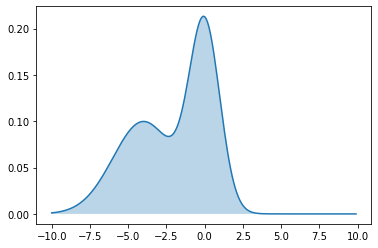

In [4]:
plt.plot(x, pdf)
plt.fill_between(x, pdf, alpha=0.3)

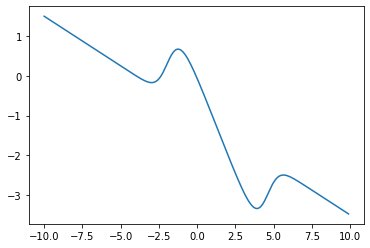

In [5]:
plt.plot(x, score_function(x))

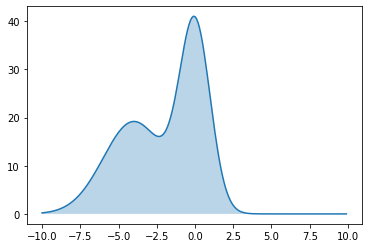

In [6]:
log_pdf = odeint(lambda y, t: jax.grad(lambda x: jnp.log(p_theta(x)))(t), jnp.log(p_theta(0.)), x)
recover_pdf = jnp.exp(log_pdf)
plt.plot(x, recover_pdf)
plt.fill_between(x, recover_pdf, alpha=0.3)

## Parameterize score function

In [7]:
d = 1
n = 10
f = lambda theta, x: theta[1] @ jnn.relu(theta[0] @ x)
key, *skey = jax.random.split(key, num=3)
theta = (jax.random.normal(skey[0], shape=(n, d)), jax.random.normal(skey[1], shape=(1, n)))

In [8]:
score = f(theta, x[None, :])
score = jnp.squeeze(score, 0)

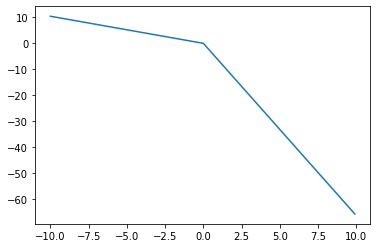

In [9]:
plt.plot(x, score)

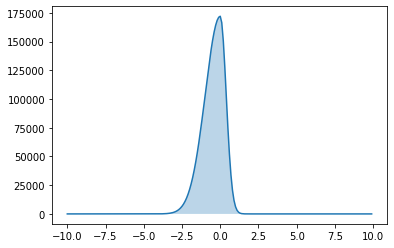

In [10]:
log_pdf = odeint(lambda y, t: f(theta, t[None]), -40., x)
recover_pdf = jnp.exp(log_pdf)
plt.plot(x, recover_pdf)
plt.fill_between(x, recover_pdf, alpha=0.3)

## Multivariate normal

In [11]:
x_lim = (-5, 5)
y_lim = (-5, 5)

In [12]:
var1_params = (jnp.array((2., 2.)), jnp.array([[1., 0.], [0., 1.]]))
var2_params = (jnp.array((-2., -2.)), jnp.array([[1., 0.], [0., 1.]]))

var1 = lambda x: multivariate_normal.pdf(x, *var1_params)
var2 = lambda x: multivariate_normal.pdf(x, *var2_params)
var_weight = jnp.array((0.5, 0.5))
pdf_2d = lambda x: var1(x)*var_weight[0] + var2(x)*var_weight[1]

In [13]:
score2d_function = jax.grad(lambda x: jnp.log(pdf_2d(x)))
score2d_function_batch = jax.vmap(jax.grad(lambda x: jnp.log(pdf_2d(x))))

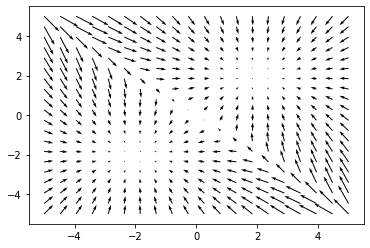

In [14]:
x,y = jnp.meshgrid(jnp.linspace(*x_lim, 20),jnp.linspace(*y_lim, 20))
points = jnp.stack((x.flatten(), y.flatten()), axis=-1)
scores  = jax.vmap(score2d_function)(points)
u, v = scores[:, 0].reshape(x.shape), scores[:, 1].reshape(y.shape)
plt.quiver(x, y, u, v)

## Langevin dynamics

In [15]:
eps = 0.5
N = 100

In [16]:
langevin_step = lambda score_function, eps, x, key: x + eps * (score_function(x))+ jnp.sqrt(2*eps)*jax.random.normal(key, shape=(N, 2))
langevin_step = jax.jit(langevin_step, static_argnums=(0,))

In [17]:
key, skey = jax.random.split(key)
num_step = 500
data = np.empty((num_step, N , 2))
data[0] = (jax.random.uniform(skey, shape=(N, 2)) - 0.5)*2*jnp.array((x_lim[1], y_lim[1]))
for i in range(1, num_step):
    key, skey  = jax.random.split(key)
    # data[i] = data[i - 1] + eps*score2d_function_batch(data[i - 1]) + jnp.sqrt(2*eps)*jax.random.normal(skey, shape=(N, 2))
    data[i] = langevin_step(score2d_function_batch, eps, data[i - 1], skey)

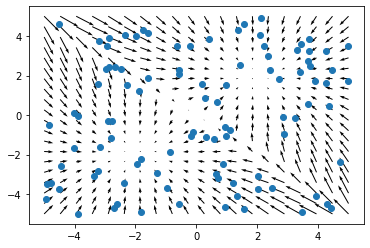

In [18]:
fig, ax = plt.subplots()
ax.quiver(x, y, u, v)
scat = ax.scatter(data[0, :, 0], data[0, :, 1])

def prepare_animation(scat):
    def animate(frame_number):
        # simulate new data coming in
        scat.set_offsets(data[frame_number])
        return scat,
    return animate
ani = animation.FuncAnimation(fig, prepare_animation(scat), data.shape[0],
                              repeat=False, blit=True)

In [19]:
# HTML(ani.to_jshtml())

## Fit to a dataset

In [20]:
import flax
import flax.linen as nn
import functools
from typing import Any, Tuple
import functools
from flax.serialization import to_bytes, from_bytes
import tensorflow as tf
from tqdm import tqdm
import optax

In [52]:
# Sample from true distribution
dataset_size = 1000
mixture_idx = np.random.choice(len(var_weight), size=dataset_size, replace=True, p=var_weight)
var_params = (var1_params, var2_params)
key, *skey = jax.random.split(key, num=3)
sample1 = jax.random.multivariate_normal(skey[0], *var_params[0], shape=(jnp.sum(mixture_idx),))
sample2 = jax.random.multivariate_normal(skey[1], *var_params[1], shape=(dataset_size - jnp.sum(mixture_idx),))
sample = jnp.concatenate((sample1, sample2))

In [53]:
sample1.shape

(496, 2)

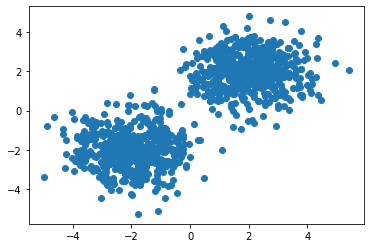

In [54]:
plt.scatter(sample[:, 0], sample[:, 1])

### Diffusion process

$$
d \mathbf{x} = f(\mathbf{x}, t) + g(t) d\mathbf{w}
$$
where $f(\cdot, t)$ is called the drift coefficient of the SDE, $g(t) \in \mathbb{R}$ is called the diffusion coefficient and $\mathbf{w}$ represents the standard Brownian motion.  

For score-based generative modeling, we will choose a diffusion process such that $\mathbf{x}(0) \sim p_0$, and $\mathbf{x}(T) \sim p_T$. Here $p_0$ is the data distribution where we have a dataset of i.i.d. samples, and $p_T$ is the prior distribution that has a tractable form and easy to sample from. The noise perturbation by the diffusion process is large enough to ensure $p_T$ does not depend on $p_0$.

### Reversing the Diffusion Process Yields Score-Based  Generative Models

### Time-Dependent Score-based Models

In [25]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    embed_dim: int
    scale: float = 30.
    @nn.compact
    def __call__(self, x):    
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        W = self.param('W', jax.nn.initializers.normal(stddev=self.scale), 
                    (self.embed_dim // 2, ))
        W = jax.lax.stop_gradient(W)
        x_proj = x[:, None] * W[None, :] * 2 * jnp.pi
        return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)

class ScoreNet(nn.Module):
    """A time-dependent score-based model.
    Args:
        marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
        channels: The number of channels for feature maps of each resolution.
        embed_dim: The dimensionality of Gaussian random feature embeddings.
    """

    marginal_prob_std: Any
    channels: Tuple[int] = (10, 20)
    embed_dim: int = 20

    @nn.compact
    def __call__(self, x, t):
        act = nn.relu
        # Obtain the Gaussian random feature embedding for t
        embed = act(nn.Dense(self.embed_dim)(GaussianFourierProjection(embed_dim=self.embed_dim)(t)))
        h1 = nn.Dense(self.channels[0])(x)
        h1 += nn.Dense(self.channels[0])(embed)
        h1 = act(h1)
        
        # h2 = nn.Dense(self.channels[1])(h1)
        # h2 += nn.Dense(self.channels[1])(embed)
        # h2 = act(h2)

        # h = nn.Dense(self.channels[0])(h1)
        # h += nn.Dense(self.channels[0])(embed)
        # h = act(h)

        h = nn.Dense(2)(h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None]
        return h

In [26]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """      
  return jnp.sqrt((sigma**(2 * t) - 1.) / 2. / jnp.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return sigma**t

sigma =  25.0 #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [27]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(rng, model, params, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A `flax.linen.Module` object that represents the structure of 
      the score-based model.
    params: A dictionary that contains all trainable parameters.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  rng, step_rng = jax.random.split(rng)
  random_t = jax.random.uniform(step_rng, (x.shape[0],), minval=eps, maxval=1.)
  rng, step_rng = jax.random.split(rng)
  z = jax.random.normal(step_rng, x.shape)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None]
  score = model.apply(params, perturbed_x, random_t)
  loss = jnp.mean(jnp.sum((score * std[:, None] + z)**2, 
                          axis=1))
  return loss

def get_train_step_fn(model, marginal_prob_std):
  """Create a one-step training function.
  
  Args:
    model: A `flax.linen.Module` object that represents the structure of 
      the score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
  Returns:
    A function that runs one step of training.
  """
  
  val_and_grad_fn = jax.value_and_grad(loss_fn, argnums=2)
  def step_fn(rng, x, optimizer):
    params = optimizer.target
    loss, grad = val_and_grad_fn(rng, model, params, x, marginal_prob_std)
    mean_grad = jax.lax.pmean(grad, axis_name='device')
    mean_loss = jax.lax.pmean(loss, axis_name='device')
    new_optimizer = optimizer.apply_gradient(mean_grad)

    return mean_loss, new_optimizer
  # return jax.pmap(step_fn, axis_name='device')
  return step_fn

In [61]:
def fit(key, sample, model, params: optax.Params, marginal_prob_std, optimizer:  optax.GradientTransformation, tqdm_epoch) -> optax.Params:
  ds = tf.data.Dataset.from_tensor_slices(sample)
  # Reduce this when image resolution is too large and data pointer is stored
  shuffle_buffer_size = 1000
  ds = ds.shuffle(shuffle_buffer_size).batch(batch_size)

  opt_state = optimizer.init(params)
  data_shape = (-1, 2)

  @jax.jit
  def step(rng, params, opt_state, batch):
    loss_value, grads = jax.value_and_grad(loss_fn, argnums=2)(rng, model, params, batch, marginal_prob_std)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value
  
  avg_loss = 0.
  num_items = 0
  for i, batch in enumerate(ds):
    batch = batch.numpy()
    key, skey = jax.random.split(key)
    params, opt_state, loss_value = step(skey, params, opt_state, batch)
    avg_loss += loss_value.item() * batch.shape[0]
    num_items += batch.shape[0]
    if i % 100 == 0:
      # Print the averaged training loss so far.
      # print('Average Loss: {:5f}'.format(avg_loss / num_items))
      tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  return params

In [62]:
n_epochs = 50
batch_size = 16
lr=1e-4
rng = jax.random.PRNGKey(0)
fake_input = jnp.ones((batch_size, 2))
fake_time = jnp.ones(batch_size)
score_model = ScoreNet(marginal_prob_std_fn)
params = score_model.init({'params': rng}, fake_input, fake_time)

In [63]:
sample.shape

(1000, 2)

In [64]:
optimizer = optax.adam(learning_rate=lr)
tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
    params = fit(rng, sample, score_model, params, marginal_prob_std_fn, optimizer, tqdm_epoch)

Average Loss: 1.490970: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s] 


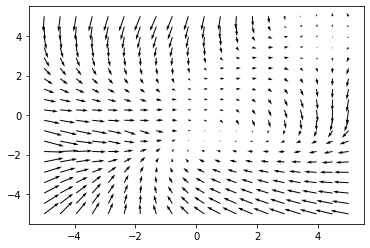

In [70]:
scores  = score_model.apply(params, points, jnp.ones((points.shape[0],))*0.1)
u, v = scores[:, 0].reshape(x.shape), scores[:, 1].reshape(y.shape)
plt.quiver(x, y, u, v)

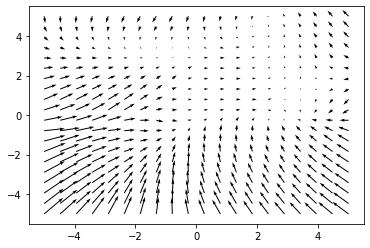